## Phase 4.38 & Appendix

***Time Series: Part II***

# Time Series Modeling



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.style.use('ggplot')

**Key points of a Time Series:**
- Constant 
    - *(Intercept)*
- Slope 
    - *(Trend)*
- Noise

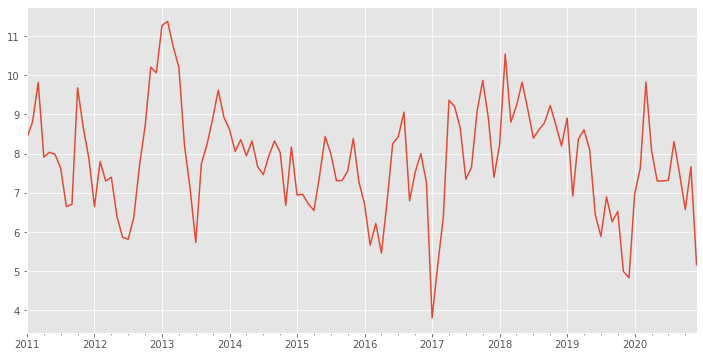

In [3]:
# Create a dataset.
np.random.seed(51)

n = 12*10
constant = 8
slope = 0.7
noise_weight = 1
noise = noise_weight*np.random.normal(size=n)
values = np.ones(n)

data = []
for i, x in enumerate(values):
    if i > 1:
        data.append(constant + slope*(data[i-1]-constant) + noise[i])
    else:
        data.append(constant + slope + noise[i])

date_vals = pd.date_range(start='01/11/2011', periods=n, freq='M')
time_series =  pd.Series(data, index=date_vals)
time_series.index = pd.DatetimeIndex(time_series.index)

time_series.plot(figsize=(12,6));

# Basic Time Series Models

> ***Important Assumption:*** *AR, MA, & ARMA models require the data can be rendered
approximately **stationary**.*

## AR: Autoregressive
An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.

In words, the mathematical idea is the following:

$$ \text{Today = constant + slope} \times \text{yesterday + noise} $$

$$\large Y_t = \mu + \phi \times Y_{t-1}+\epsilon_t$$

In [4]:
from statsmodels.tsa.arima_model import ARMA

In [5]:
ar_model = ARMA(time_series, order=(1,0)).fit()

ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(1, 0)   Log Likelihood                -172.444
Method:                       css-mle   S.D. of innovations              1.016
Date:                Tue, 20 Apr 2021   AIC                            350.889
Time:                        15:35:47   BIC                            359.251
Sample:                    01-31-2011   HQIC                           354.285
                         - 12-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8009      0.272     28.644      0.000       7.267       8.335
ar.L1.y        0.6648      0.069      9.622      0.000       0.529       0.800
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5043           +0.0000j            1.5043            0.0000
-----------------------------------------------------------------------------
"""

In [6]:
print('Predefined: (Constant, Slope)', (constant, slope))

ar_model.params

Predefined: (Constant, Slope) (8, 0.7)


const      7.800888
ar.L1.y    0.664768
dtype: float64

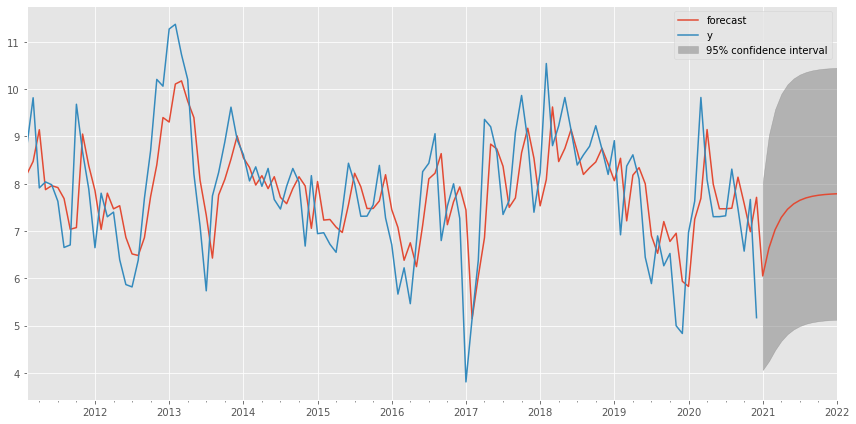

In [7]:
# Predict the entire window of time.
fig, ax = plt.subplots(figsize=(12,6))

ar_model.plot_predict(1, n+12, ax=ax)

fig.tight_layout()

### AR(2)

$$ \text{Today} = \text{constant} + (slope_1 \times \text{yesterday}) + (slope_2 \times \text{two days ago) + noise} $$

In [8]:
ar_model_2 = ARMA(time_series, order=(2,0)).fit()
ar_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 0)   Log Likelihood                -171.580
Method:                       css-mle   S.D. of innovations              1.008
Date:                Tue, 20 Apr 2021   AIC                            351.161
Time:                        15:35:47   BIC                            362.311
Sample:                    01-31-2011   HQIC                           355.689
                         - 12-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8038      0.243     32.152      0.000       7.328       8.280
ar.L1.y        0.7467      0.093      8.067      0.000       0.565       0.928
ar.L2.y       -0.1221      0.092     -1.320      0.189      -0.303       0.059
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9801           +0.0000j            1.9801            0.0000
AR.2            4.1372           +0.0000j            4.1372            0.0000
-----------------------------------------------------------------------------
"""

In [9]:
print('Predefined: (Constant, Slope)', (constant, slope))

ar_model_2.params

Predefined: (Constant, Slope) (8, 0.7)


const      7.803825
ar.L1.y    0.746728
ar.L2.y   -0.122068
dtype: float64

In [10]:
# Comparing models.
ar_model.aic, ar_model_2.aic

(350.88899680529164, 351.16082653500786)

### Train Test Split: By Hand
- Using a train-test-split by randomly shuffling data points does not work the same way for time series data.
    - *We don't want to train the model on data points from the future in order to predict the past!*
    
    
- We can split our data by hand, or train-test-split without shuffling the data in order to get our most recent $n$% assigned as our **test**.

In [11]:
# Train test split by hand.
SPLIT = int(time_series.shape[0]*0.8)
train, test = time_series[:SPLIT], time_series[SPLIT:]

train.shape, test.shape

((96,), (24,))

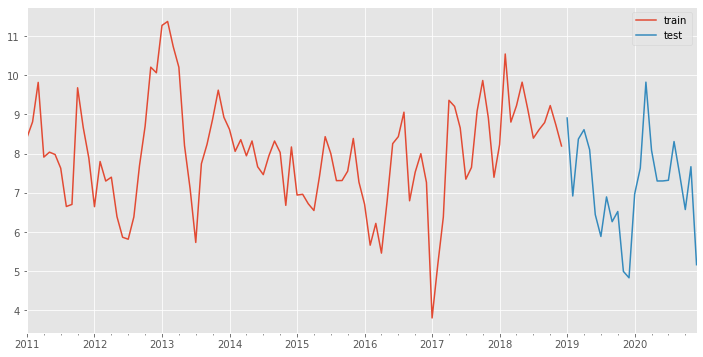

In [12]:
df = pd.DataFrame()
df['original'] = time_series
df['train'] = train
df['test'] = test

df[['train', 'test']].plot(figsize=(12,6));

In [13]:
from sklearn.metrics import mean_squared_error

In [14]:
ar_model = ARMA(train, order=(1,0)).fit()
predictions_ar_1 = ar_model.forecast(steps=test.shape[0])[0]

ar_model_2 = ARMA(train, order=(2,0)).fit()
predictions_ar_2 = ar_model_2.forecast(steps=test.shape[0])[0]

In [15]:
mse_ar_1 = round(mean_squared_error(test, predictions_ar_1), 3)
mse_ar_2 = round(mean_squared_error(test, predictions_ar_2), 3)

print(f'MSE\n\tAR_1\t{mse_ar_1}\n\tAR_2\t{mse_ar_2}')

MSE
	AR_1	2.16
	AR_2	2.138


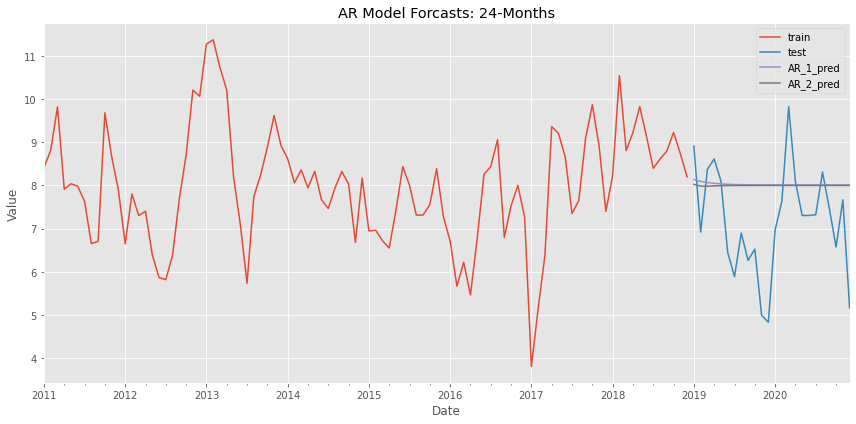

In [16]:
pred_1 = pd.Series(predictions_ar_1, index=test.index, name='AR_1_pred')
pred_2 = pd.Series(predictions_ar_2, index=test.index, name='AR_2_pred')

full_df = pd.concat([df, pred_1, pred_2], axis=1).drop('original', axis=1)

fig, ax = plt.subplots(figsize=(12,6))
full_df.plot(ax=ax)
ax.set(title='AR Model Forcasts: 24-Months', xlabel='Date', ylabel='Value')
fig.tight_layout()

## MA: Moving Average

The Moving Average model can be described as the weighted sum of today's and yesterday's noise.

In words, the mathematical idea is the following:

$$ \text{Today = Mean + Noise + Slope x yesterday's noise} $$
 

$$\large Y_t=\mu+\epsilon t + \phi \times \epsilon t - 1$$

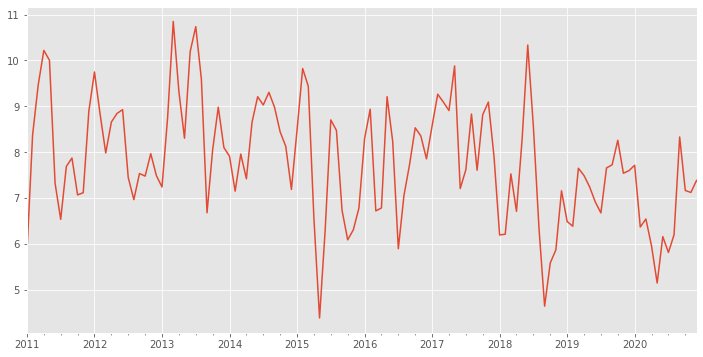

In [17]:
# Create data
n = 12*10
mu = 8
theta = 0.9
noise_weight = 1
errors = noise_weight*np.random.normal(size=n)
values = np.ones(n)
data = []
for i,x in enumerate(values):
    data.append(mu + theta*errors[i-1] + errors[i] if i>1 else mu + errors[i])
date_vals = pd.date_range(start='01/11/2011', periods=n, freq='M')
time_series =  pd.Series(data, index=date_vals)
time_series.index = pd.DatetimeIndex(time_series.index)

time_series.plot(figsize=(12,6));

In [18]:
ma_model = ARMA(time_series, order=(0,1)).fit()

ma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(0, 1)   Log Likelihood                -164.750
Method:                       css-mle   S.D. of innovations              0.950
Date:                Tue, 20 Apr 2021   AIC                            335.500
Time:                        15:35:49   BIC                            343.862
Sample:                    01-31-2011   HQIC                           338.896
                         - 12-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7789      0.158     49.222      0.000       7.469       8.089
ma.L1.y        0.8283      0.055     15.159      0.000       0.721       0.935
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2072           +0.0000j            1.2072            0.5000
-----------------------------------------------------------------------------
"""

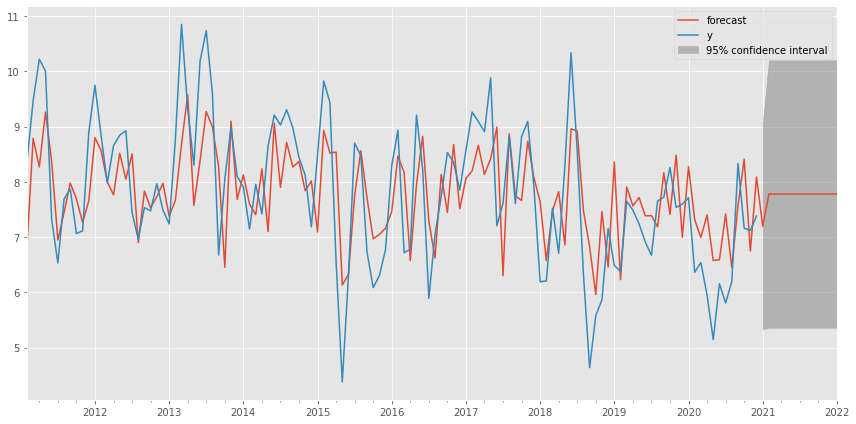

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ma_model.plot_predict(1, n+12, ax=ax)
fig.tight_layout()

# ARMA: AR + MA

Combines both components into the model.

AR
$$\large Y_t = \mu + \phi \times Y_{t-1}+\epsilon_t$$

MA
$$\large Y_t=\mu+\epsilon t + \phi \times \epsilon t - 1$$

$$ \large Y_t = \mu + \phi \times Y_t-1 + \theta \times \epsilon t - 1 + \epsilon t  $$

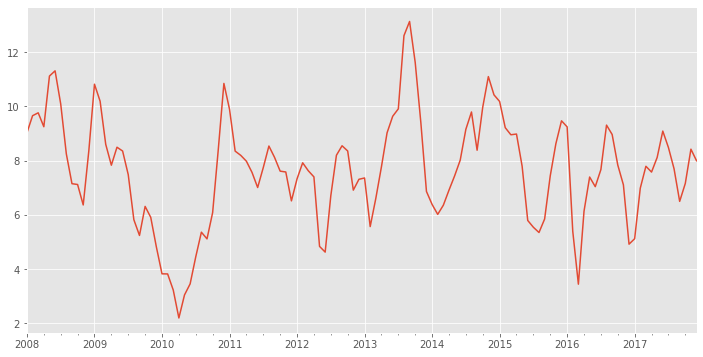

In [20]:
# Make data
n = 12*10
mu = 8
phi = 0.7
theta = 0.9
noise_weight = 1
errors = noise_weight*np.random.normal(size=n)
values = np.ones(n)

data = []
for i,x in enumerate(values):
    data.append(mu + phi*(data[i-1]-mu) + errors[i] + theta*errors[i-1]  if i>1 else mu + phi + errors[i])
date_vals = pd.date_range(start='1/1/2008', periods=n, freq='M')
time_series =  pd.Series(data, index=date_vals)
time_series.index = pd.DatetimeIndex(time_series.index)

time_series.plot(figsize=(12,6));

In [21]:
arma_model = ARMA(time_series, order=(1,1)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(1, 1)   Log Likelihood                -159.270
Method:                       css-mle   S.D. of innovations              0.889
Date:                Tue, 20 Apr 2021   AIC                            326.541
Time:                        15:35:50   BIC                            337.691
Sample:                    01-31-2008   HQIC                           331.069
                         - 12-31-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6665      0.403     19.019      0.000       6.876       8.457
ar.L1.y        0.6038      0.072      8.373      0.000       0.462       0.745
ma.L1.y        1.0000      0.066     15.198      0.000       0.871       1.129
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6561           +0.0000j            1.6561            0.0000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
-----------------------------------------------------------------------------
"""

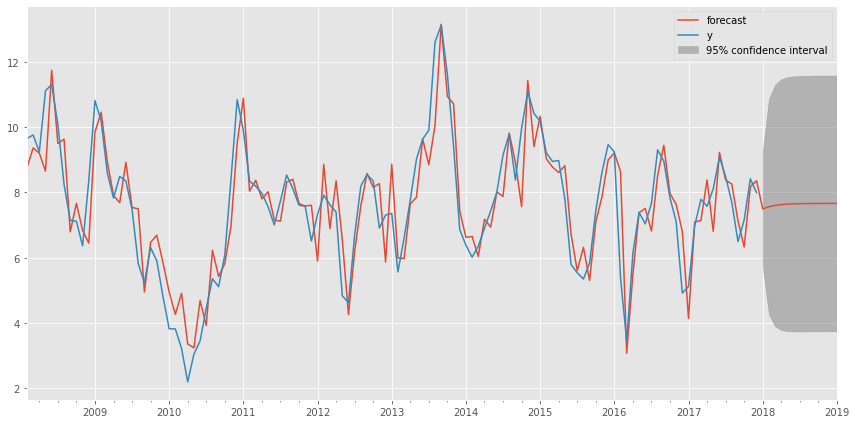

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
arma_model.plot_predict(1, n+12, ax=ax)
fig.tight_layout()

# ARIMA: ARMA + Integration (Trends)

> ***ARIMA & SARIMA models do not assume stationarity.***

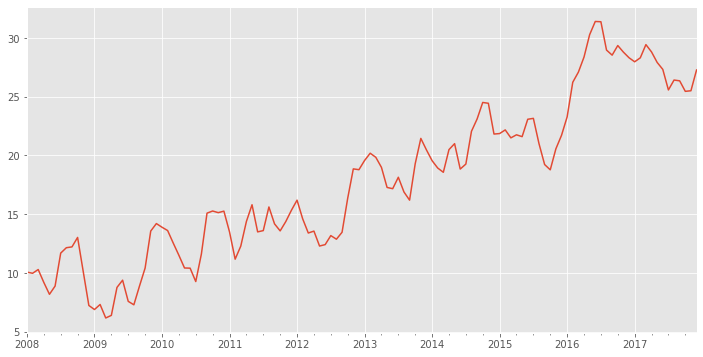

In [23]:
# Create data
n = 12*10
mu = 8
phi = 0.7
theta = 0.9
noise_weight = 1
errors = noise_weight*np.random.normal(size=n)
values = np.ones(n)

data = []
for i,x in enumerate(values):
    if i > 1:
        data.append(
            mu + phi * (data[i-1]-mu) + errors[i] + theta*errors[i-1] + 0.05*i)
    else:
        data.append(mu + phi + errors[i])
date_vals = pd.date_range(start='1/1/2008', periods=n, freq='M')
time_series =  pd.Series(data, index=date_vals)
time_series.index = pd.DatetimeIndex(time_series.index)

time_series.plot(figsize=(12,6));

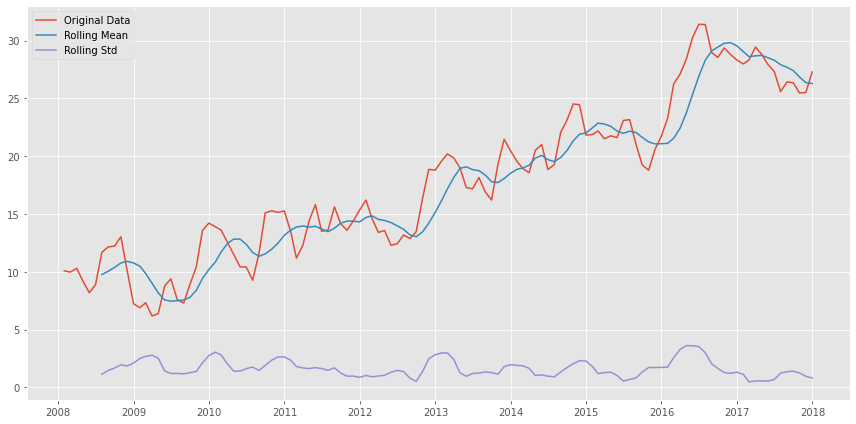

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time_series, label='Original Data')
ax.plot(time_series.rolling(7).mean(), label='Rolling Mean')
ax.plot(time_series.rolling(7).std(), label='Rolling Std')
ax.legend()
fig.tight_layout()

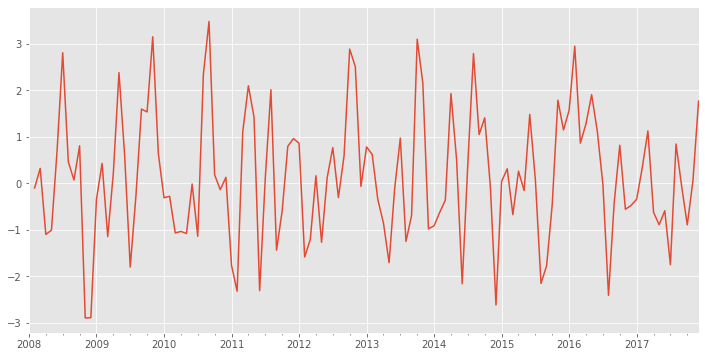

In [25]:
time_series.diff(1).plot(figsize=(12, 6));

In [26]:
from statsmodels.tsa.arima_model import ARIMA

In [27]:
arima_model = ARIMA(time_series, order=(1,1,1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -185.203
Method:                       css-mle   S.D. of innovations              1.139
Date:                Tue, 20 Apr 2021   AIC                            378.407
Time:                        15:35:52   BIC                            389.523
Sample:                    02-29-2008   HQIC                           382.921
                         - 12-31-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1506      0.160      0.942      0.348      -0.163       0.464
ar.L1.D.y     -0.2682      0.099     -2.707      0.008      -0.462      -0.074
ma.L1.D.y      0.9459      0.040     23.393      0.000       0.867       1.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.7284           +0.0000j            3.7284            0.5000
MA.1           -1.0572           +0.0000j            1.0572            0.5000
-----------------------------------------------------------------------------
"""

In [28]:
arima_model.aic

378.4065491553526

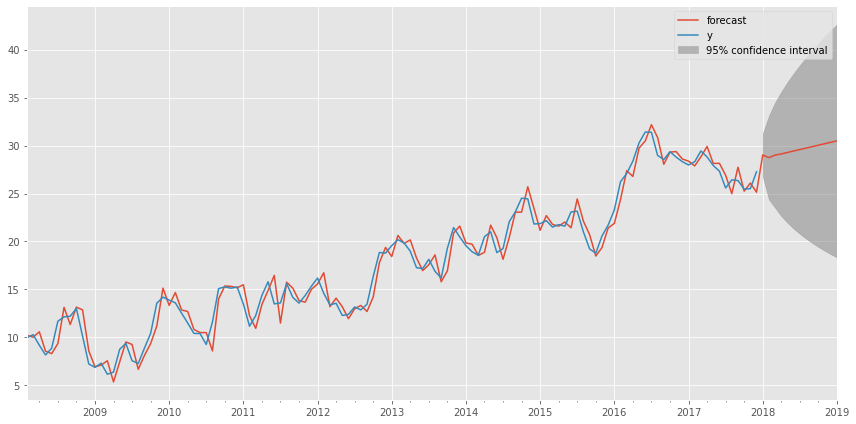

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
arima_model.plot_predict(1, n+12, ax=ax)
fig.tight_layout()

In [30]:
# Iterating through p, d, q values.
p = q = (0,1,2)
diff = 1

combo, value = (None, None)
for ar in p:
    for ma in q:
        try:
            model = ARIMA(time_series, order=(ar, diff, ma)).fit()
            print('Combo:', (ar, diff, ma),'AIC:', model.aic)

            if value is None or model.aic < value:
                combo, value = ((ar, diff, ma), model.aic)
                print(f'\tBest Parameters Updated')
        except ValueError:
            pass
            
print(f'\n{"*"*20}\nOptimal ARIMA order: {combo}')

Combo: (0, 1, 0) AIC: 419.5535215391019
	Best Parameters Updated
Combo: (0, 1, 1) AIC: 383.74253724055944
	Best Parameters Updated
Combo: (0, 1, 2) AIC: 376.6610504917661
	Best Parameters Updated
Combo: (1, 1, 0) AIC: 410.77513796598384
Combo: (1, 1, 1) AIC: 378.4065491553526
Combo: (1, 1, 2) AIC: 367.622012037241
	Best Parameters Updated
Combo: (2, 1, 0) AIC: 397.652112929173
Combo: (2, 1, 1) AIC: 378.8809601515574

********************
Optimal ARIMA order: (1, 1, 2)


In [31]:
arima_model_best = ARIMA(time_series, order=combo).fit()
arima_model_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -178.811
Method:                       css-mle   S.D. of innovations              1.065
Date:                Tue, 20 Apr 2021   AIC                            367.622
Time:                        15:35:53   BIC                            381.518
Sample:                    02-29-2008   HQIC                           373.265
                         - 12-31-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1779      0.014     12.481      0.000       0.150       0.206
ar.L1.D.y      0.6414      0.074      8.678      0.000       0.497       0.786
ma.L1.D.y     -0.0772      0.050     -1.544      0.125      -0.175       0.021
ma.L2.D.y     -0.9227      0.049    -18.901      0.000      -1.018      -0.827
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5592           +0.0000j            1.5592            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0837           +0.0000j            1.0837            0.5000
-----------------------------------------------------------------------------
"""

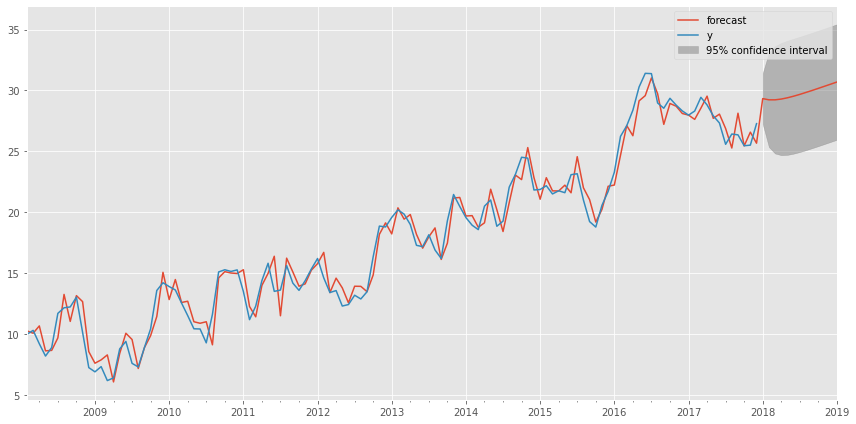

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
arima_model_best.plot_predict(1, n+12, ax=ax)
fig.tight_layout()

# SARIMA: ARIMA + Seasonality

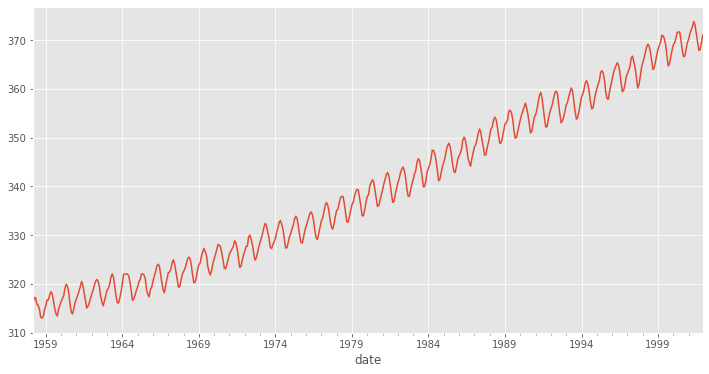

In [33]:
# Load the dataset
dataset = sm.datasets.co2.load(as_pandas=False).data
df = pd.DataFrame(dataset)

# Update to datetime type
df['date'] = pd.to_datetime(df['index'])
df.set_index(df['date'], inplace=True)
df = df.asfreq(df.index.inferred_freq)

df.drop(['date', 'index'], axis=1, inplace=True)
df = df.bfill()

CO2 = df['co2'].resample('MS').mean()
CO2.plot(figsize=(12,6));

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [35]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

# Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            CO2, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7612.577300304358
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6787.353894474736
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 1854.5529883366798
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 1593.6859335419297
SARIMA Combos: ((0, 0, 0), (1, 0, 0, 12)) AIC: 1051.4507518592218
SARIMA Combos: ((0, 0, 0), (1, 0, 1, 12)) AIC: 1049.019630769415
SARIMA Combos: ((0, 0, 0), (1, 1, 1, 12)) AIC: 1038.3101108425462


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA Combos: ((0, 0, 1), (1, 0, 1, 12)) AIC: 757.6054644074494
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 595.9585828564279
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 297.8377966235634


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA Combos: ((0, 1, 0), (1, 1, 1, 12)) AIC: 289.0667909378052
SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 268.8677930978432
SARIMA Combos: ((0, 1, 1), (1, 1, 1, 12)) AIC: 257.273873033795


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 252.2850887202572

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [36]:
combo

((1, 1, 1), (1, 1, 1, 12))

In [37]:
# Manually split data.
SPLIT = int(CO2.shape[0]*0.8)
train, test = CO2[:SPLIT], CO2[SPLIT:]

# Model
sarima_model_best = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  420
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -103.582
Date:                            Tue, 20 Apr 2021   AIC                            217.164
Time:                                    15:36:25   BIC                            237.033
Sample:                                03-01-1958   HQIC                           225.038
                                     - 02-01-1993                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4644      0.093      5.012      0.000       0.283       0.646
ma.L1         -0.7321      0.072    -10.113      0.000      -0.874      -0.590
ar.S.L12      -0.0008      0.000     -1.831      0.067      -0.002    5.52e-05
ma.S.L12      -0.8752      0.030    -28.812      0.000      -0.935      -0.816
sigma2         0.0956      0.006     15.884      0.000       0.084       0.107
===================================================================================
Ljung-Box (Q):                       29.28   Jarque-Bera (JB):                22.87
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.26
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

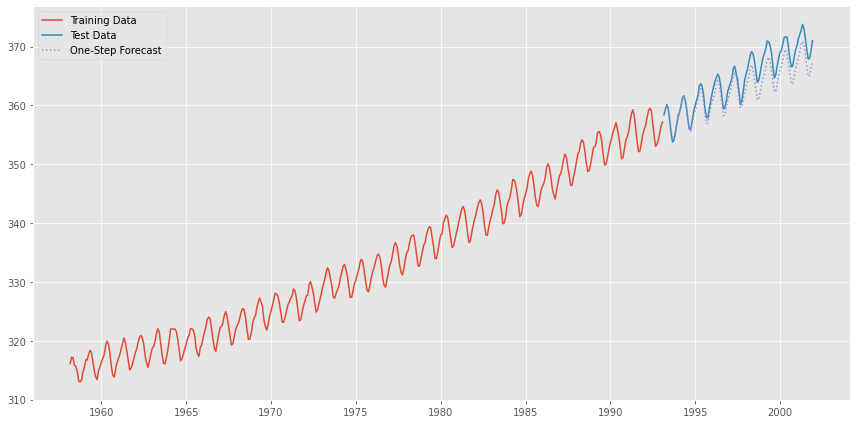

In [38]:
pred = sarima_model_best.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
ax.legend()
fig.tight_layout()

In [39]:
pred.conf_int()

,lower co2,upper co2
1993-03-01,357.679778,358.892029
1993-04-01,358.840471,360.343008
1993-05-01,359.321661,360.995227
1993-06-01,358.651613,360.453214
1993-07-01,356.978546,358.888625
...,...,...
2001-08-01,361.977184,371.382456
2001-09-01,360.233008,369.715978
2001-10-01,360.274015,369.834000
2001-11-01,361.475222,371.111583


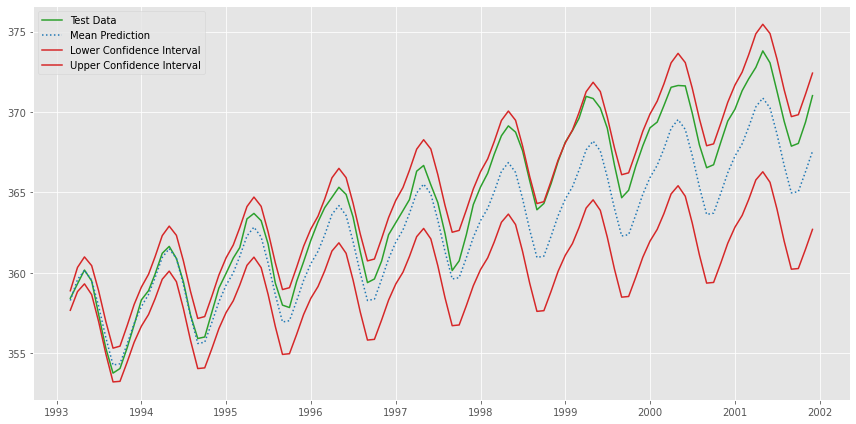

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower co2'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper co2'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.legend()
fig.tight_layout()